<a href="https://colab.research.google.com/github/comparativechrono/microscoPi/blob/main/analysis/Heart_rate_extraction_from_mjpeg_video_recordings_of_Daphnia_pulex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart rate extraction from mjpeg video recordings of *Daphnia pulex*

This notebook accompanies the study **"Photoperiodic and Intrinsic Circadian Regulation of Heart Rate in *Daphnia pulex*"** and presents a pipeline for extracting and analyzing heartbeat data from short video recordings. This notebook provides a reproducible method for non-invasive, high-throughput analysis of heart rate in *Daphnia*, and can be adapted for similar image-based physiological measurements in other model systems.


### Overview

The goal of this analysis is to estimate the heart rate of *Daphnia pulex* by analyzing pixel intensity fluctuations in video recordings. These fluctuations reflect periodic contractions of the heart, and are analyzed using a combination of time-domain and frequency-domain methods.

### Workflow Summary

1. **Video Processing and Signal Extraction**  
   Each frame of a 10-second `.mjpeg` video is processed to calculate the total pixel intensity across all colour channels. This produces a time series representing changes in overall colour, which serves as a proxy for heartbeat activity.

2. **Time-Domain Peak Detection**  
   Peaks in the colour signal are detected using `scipy.signal.find_peaks`, allowing for a simple estimate of heart rate based on beat count.

3. **Frequency-Domain Analysis (FFT)**  
   A Fast Fourier Transform (FFT) is applied to convert the signal to the frequency domain, identifying the dominant frequency corresponding to heart rate.

4. **Sinusoidal Curve Fitting (FFT-NLLS)**  
   A sinusoidal model is fit to the detrended signal using nonlinear least squares (NLLS), providing refined estimates of heartbeat frequency, amplitude, phase, and baseline offset.

5. **Visualization and Interpretation**  
   Results are plotted for both time and frequency domains, and final BPM estimates are reported for each individual recording.

These packages are required for video processing, signal analysis, and visualization:

- **opencv-python**: For loading and processing video frames.
- **numpy**: For efficient numerical operations on arrays and time series.
- **matplotlib**: For plotting and visualizing the heartbeat signal and analysis results.
- **scipy**: For signal processing (e.g. peak detection, FFT) and curve fitting.


In [ ]:
pip install opencv-python numpy matplotlib scipy


## Heart Rate Estimation from Video Using Total Colour Intensity Method

This script processes a 10-second video recording to estimate the heart rate of *Daphnia pulex* based on subtle fluctuations in pixel intensity over time. The analysis is based on the **Total Colour Method**, where the sum of pixel values across each video frame is calculated. This method captures variations in overall colour intensity, which can reflect rhythmic contractions of the heart. Because heartbeats cause transient changes in light intensity (especially when imaging with transmitted or reflected light), these fluctuations can be detected as peaks in the total colour signal.

### Key Steps

1. **Video Input**:  
   The script loads a `.mjpeg` video file containing a 10-second recording of *Daphnia pulex*.

2. **Colour Summation**:  
   For each frame in the video, the total colour value is computed by summing pixel intensities across all channels (RGB) and all pixels. This produces a 1D time series of total colour values.

3. **Frame Timestamps**:  
   Timestamps for each frame are recorded in milliseconds and adjusted to begin at zero for consistency.

4. **Clipping the Final 10 Seconds**:  
   Raspberry Pi videos are always shorter than the requested duration, and contain focussing noise. We suggest imaging for 12 seconsds, and then only the last 10 seconds of data are used to eliminate potential artefacts from the start of the video.

5. **Heartbeat Detection**:  
   Peaks in the total colour signal are detected using the `scipy.signal.find_peaks` function. These peaks correspond to individual heartbeats.

6. **Visualization**:  
   The total colour signal is plotted over time (in seconds), with detected peaks highlighted to visually confirm heartbeat detection.

7. **Heart Rate Calculation**:  
   The number of detected peaks over the 10-second window is multiplied by 6 to estimate the heart rate in **Beats Per Minute (BPM)**. The last image in the video stack is saved, so you can illustrate your graph.


Last frame saved as 'last_frame.png'


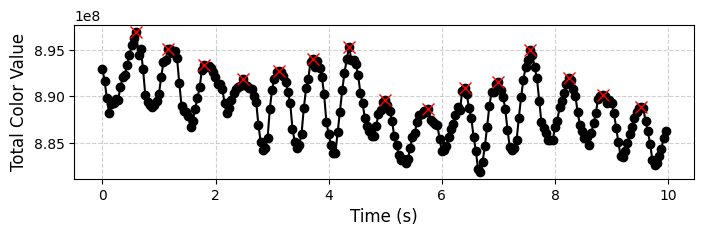

Estimated Beats Per Minute: 90


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the video
cap = cv2.VideoCapture('heart6_2.mjpeg')

total_colors = []
timestamps = []
last_frame = None  # Placeholder for the last frame


# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    last_frame = frame.copy()  # Store the last frame

    # Compute the total color
    total_color = np.sum(frame, axis=(0, 1))
    total_colors.append(np.sum(total_color))
    timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))

cap.release()

# Save the last frame as an image
if last_frame is not None:
    cv2.imwrite("last_frame.png", last_frame)
    print("Last frame saved as 'last_frame.png'")

# Convert to numpy array for analysis
total_colors = np.array(total_colors)
timestamps = np.array(timestamps)

# Adjust timestamps before clipping to remove video meta data artefacts
timestamps -= timestamps[0]

# Clip the data to analyze only the last 10 seconds (10,000 ms)
if timestamps[-1] > 10000:
    start_time = timestamps[-1] - 10000  # 10 seconds in milliseconds
    mask = timestamps >= start_time
    total_colors = total_colors[mask]
    timestamps = timestamps[mask]

# Adjust timestamps after clipping
timestamps -= timestamps[0]

# Find peaks for heartbeat
peaks, _ = find_peaks(total_colors, distance=10)  # Adjust parameters as needed

# Convert time to seconds
timestamps_sec = [t / 1000 for t in timestamps]

# Adjust figure size (reduce height to half)
fig, ax = plt.subplots(figsize=(8, 2))  # Half the typical height

# Plot with new colors
ax.plot(timestamps_sec, total_colors, color='black', marker='o', linestyle='-')  # Black for main line
ax.plot([timestamps_sec[i] for i in peaks], [total_colors[i] for i in peaks], "x", color='red', markersize=8)  # Red for peaks

# Add grid for readability
ax.grid(True, linestyle='--', alpha=0.6)

# Labels and title
ax.set_xlabel("Time (s)", fontsize=12)  # Updated to seconds
ax.set_ylabel("Total Color Value", fontsize=12)

# Show plot
plt.show()

# Calculate BPM
bpm = len(peaks) * 6  # Adjusted for 10-second window
print(f"Estimated Beats Per Minute: {bpm}")


## Frequency Domain Analysis and Sinusoidal Curve Fitting of Heartbeat Signal

Building on the time-domain analysis, this section applies **Fast Fourier Transform (FFT)** to the total colour signal to identify the dominant frequency component, corresponding to the heart rate of *Daphnia pulex*. The analysis is further refined using **nonlinear least squares (NLLS)** fitting of a sinusoidal model to the detrended signal, allowing for a more accurate estimation of heartbeat frequency and amplitude.

### Key Steps

1. **Video Metadata Extraction**  
   The script extracts the video frame rate (FPS), which is required to calculate accurate frequency values from the time series.

2. **Detrending**  
   To remove baseline shifts and isolate the oscillatory component, the mean value is subtracted from the signal (DC offset removal).

3. **FFT: Frequency Domain Transformation**  
   The detrended signal is transformed into the frequency domain using the FFT:
   - The amplitude spectrum is computed to visualize the dominant frequency.
   - The frequency with the highest amplitude is taken as the **initial estimate** of the heartbeat frequency.
   - An initial estimate of amplitude and phase is also extracted from the FFT result.

4. **Heart Rate Estimation (FFT-based)**  
   The dominant frequency (in Hz) is converted to **Beats Per Minute (BPM)** by multiplying by 60.

5. **Model Definition and Curve Fitting (FFT-NLLS)**  
   A sinusoidal model is defined with four parameters: amplitude, frequency, phase, and offset.  
   Using the FFT-based estimates as initial guesses, the model is fitted to the time-domain signal using `scipy.optimize.curve_fit`, yielding refined estimates of these parameters.

6. **Visualization**  
   - The FFT amplitude spectrum is plotted to visualize frequency components of the signal.
   - The detrended signal is plotted alongside the fitted sinusoid, with detected peaks marked for reference.



Initial FFT-based guesses:
Amplitude: 2866136.323, Frequency: 1.600 Hz, Phase: -0.456 rad, Offset: 0.0


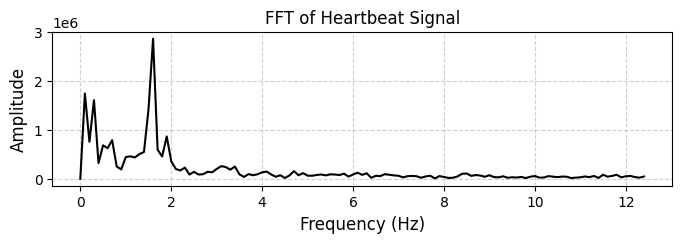

Heart Rate: 96.00 beats per minute

Fitted parameters from FFT-NLLS:
Amplitude = 3397999.309
Frequency = 1.568 Hz
Phase = 2.161 rad
Offset = 45474.183
Estimated Heart Rate: 94.08 BPM


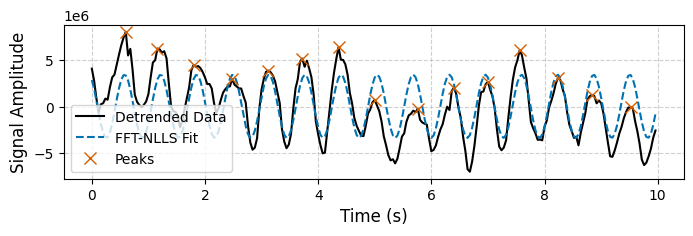

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.fftpack import fftfreq

# -------------------------------
# Load video, detrend and get timestamps
# -------------------------------

# Load the video and get frame rate
cap = cv2.VideoCapture('heart6_2.mjpeg')
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

# Detrend the signal by removing the DC offset
total_colors_detrended = total_colors - np.mean(total_colors)

# Number of sample points
N = len(total_colors_detrended)

# Sample spacing (in seconds)
T = 1.0 / fps  # For example, if fps is 30, T is ~0.0333 sec

# Convert timestamps to seconds (if they are in milliseconds)
t = timestamps / 1000.0

# -------------------------------
# FFT Step: Compute FFT to get initial parameter estimates
# -------------------------------
yf = fft(total_colors_detrended)
xf = fftfreq(N, T)[:N//2]

# Compute the amplitude spectrum (scaled)
amplitudes = 2.0 / N * np.abs(yf[0:N//2])
peak_index = np.argmax(amplitudes)

# Use FFT results as initial guesses
initial_frequency = xf[peak_index]
initial_amplitude = amplitudes[peak_index]
initial_phase = np.angle(yf[peak_index])
initial_offset = 0.0  # We already removed the mean

print("Initial FFT-based guesses:")
print(f"Amplitude: {initial_amplitude:.3f}, Frequency: {initial_frequency:.3f} Hz, "
      f"Phase: {initial_phase:.3f} rad, Offset: {initial_offset}")

fig, ax = plt.subplots(figsize=(8, 2))  # Adjusted figure size
# Plot FFT amplitude using a black line with circle markers
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='black', linestyle='-')
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_title("FFT of Heartbeat Signal", fontsize=12)
ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("Amplitude", fontsize=12)
plt.show()

# Find the index of the peak frequency (ignore the DC component)
# Since the signal is detrended, the DC peak should now be minimized.
peak_frequency_index = np.argmax(2.0/N * np.abs(yf[0:N//2]))
heart_rate_hz = xf[peak_frequency_index]
heart_rate_bpm = heart_rate_hz * 60

print(f"Heart Rate: {heart_rate_bpm:.2f} beats per minute")

# -------------------------------
# Define the sinusoidal model for the NLLS fitting
# -------------------------------
def sinusoid(t, A, f, phi, offset):
    return A * np.sin(2 * np.pi * f * t + phi) + offset

# -------------------------------
# NLLS Step: Fit the sinusoid model to the detrended signal
# -------------------------------
# Initial parameter guess vector
p0 = [initial_amplitude, initial_frequency, initial_phase, initial_offset]

# Use curve_fit to optimize the model parameters
params, params_covariance = curve_fit(sinusoid, t, total_colors_detrended, p0=p0)
A_fit, f_fit, phi_fit, offset_fit = params

# Compute heart rate in beats per minute (BPM)
heart_rate_bpm = f_fit * 60

print("\nFitted parameters from FFT-NLLS:")
print(f"Amplitude = {A_fit:.3f}")
print(f"Frequency = {f_fit:.3f} Hz")
print(f"Phase = {phi_fit:.3f} rad")
print(f"Offset = {offset_fit:.3f}")
print(f"Estimated Heart Rate: {heart_rate_bpm:.2f} BPM")

# -------------------------------
# Plot the detrended data and fitted sinusoid with updated style
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 2))  # Adjusted figure size
# Plot detrended data in black with circle markers
ax.plot(t, total_colors_detrended, label='Detrended Data', color='black', linestyle='-')
# Plot the fitted sinusoid as a red dashed line
ax.plot(t, sinusoid(t, *params), label='FFT-NLLS Fit', color='#0072B2', linestyle='--')
ax.plot([timestamps_sec[i] for i in peaks], [total_colors_detrended[i] for i in peaks], "x", label='Peaks', color='#D55E00', markersize=8)  # Red for peaks
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Signal Amplitude", fontsize=12)
#ax.set_title("FFT-NLLS Fit to Heartbeat Signal", fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()
